# Deep Learning Models for Malware Detection

This notebook implements three deep learning architectures for malware detection:
1. Convolutional Neural Network (CNN) - For temporal pattern detection
2. Long Short-Term Memory (LSTM) - For sequential dependencies
3. Multi-Layer Perceptron (MLP) - For non-linear feature combinations

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plot style using seaborn
sns.set_style('whitegrid')
plt.style.use('default')


In [23]:
def load_and_preprocess_data(file_path):
    """Load and preprocess the malware detection features"""
    # Load data
    df = pd.read_csv(file_path)
    
    # Separate features and labels
    X = df.drop('label', axis=1)
    y = df['label']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Reshape data for deep learning models
    # For Conv1D: (batch_size, timesteps, features)
    # We'll treat each feature as a timestep
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1, 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1, 1)
    
    return X_train, X_test, X_train_reshaped, X_test_reshaped, y_train, y_test, X.columns

def plot_training_history(history, title):
    """Plot training history for accuracy and loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def visualize_layer_activations(model, layer_name, X_sample):
    """Visualize activations of a specific layer for a sample input"""
    try:
        # Create a model that outputs the layer activations
        layer_model = Model(inputs=model.input,
                        outputs=model.get_layer(layer_name).output)
        
        # Get layer activations
        activations = layer_model.predict(X_sample[np.newaxis, ...], verbose=0)
        
        # Plot activations
        plt.figure(figsize=(12, 4))
        plt.imshow(activations[0].T, aspect='auto', cmap='viridis')
        plt.title(f'Layer {layer_name} Activations')
        plt.xlabel('Time Step')
        plt.ylabel('Feature Map')
        plt.colorbar(label='Activation')
        plt.show()
    except ValueError as e:
        print(f"Error: {e}\nAvailable layers:")
        for i, layer in enumerate(model.layers):
            print(f"Layer {i}: {layer.name}")

In [24]:
# Load and preprocess data
print("Loading and preprocessing data...")
X_train, X_test, X_train_reshaped, X_test_reshaped, y_train, y_test, feature_names = \
    load_and_preprocess_data('malware_detection_features.csv')

print("\nData shapes:")
print(f"Training data: {X_train_reshaped.shape}")
print(f"Test data: {X_test_reshaped.shape}")
print(f"Number of features: {len(feature_names)}")

Loading and preprocessing data...

Data shapes:
Training data: (8000, 10, 1)
Test data: (2000, 10, 1)
Number of features: 10


## 1. Convolutional Neural Network (CNN)

Implement a CNN model for detecting temporal patterns in malware features. CNNs are effective at identifying local patterns and feature hierarchies.

In [25]:
def visualize_conv_layer(model, X_sample):
    """Visualize the first convolutional layer's activations with proper model initialization"""
    # Find the first Conv1D layer
    conv_layer = None
    for layer in model.layers:
        if isinstance(layer, Conv1D):
            conv_layer = layer
            break
    
    if conv_layer is None:
        print("No convolutional layer found in the model.")
        return
    
    # Build a new model up to the conv layer
    inputs = Input(shape=model.input_shape[1:])
    x = inputs
    for layer in model.layers:
        x = layer(x)
        if layer == conv_layer:
            break
    
    feature_model = Model(inputs=inputs, outputs=x)
    
    # Get activations
    activations = feature_model.predict(X_sample[np.newaxis, ...], verbose=0)
    
    # Plot activations
    plt.figure(figsize=(12, 4))
    plt.imshow(activations[0].T, aspect='auto', cmap='viridis')
    plt.title(f'Layer {conv_layer.name} Activations')
    plt.xlabel('Time Step')
    plt.ylabel('Feature Map')
    plt.colorbar(label='Activation')
    plt.show()

In [26]:
def create_cnn_model(input_shape):
    """Create a CNN model for malware detection"""
    model = Sequential([
        # First Convolutional Block
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        
        # Global Pooling and Dense Layers
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Training CNN model...


c:\Users\thinkbook\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 10, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 10, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 10, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 5, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 5, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,521 (123.13 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/50
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6662 - loss: 0.7203

200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6685 - loss: 0.7161 - val_accuracy: 0.7650 - val_loss: 0.5721
Epoch 2/50
Epoch 2/50
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7427 - loss: 0.5586

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7432 - loss: 0.5575 - val_accuracy: 0.8019 - val_loss: 0.4511
Epoch 3/50
Epoch 3/50
191/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7667 - loss: 0.4911

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7671 - loss: 0.4907 - val_accuracy: 0.8106 - val_loss: 0.4133
Epoch 4/50
Epoch 4/50
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7839 - loss: 0.4652

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7840 - loss: 0.4650 - val_accuracy: 0.8106 - val_loss: 0.3982
Epoch 5/50
Epoch 5/50
191/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7871 - loss: 0.4514

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7872 - loss: 0.4511 - val_accuracy: 0.8163 - val_loss: 0.3948
Epoch 6/50
Epoch 6/50
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7945 - loss: 0.4476

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7945 - loss: 0.4475 - val_accuracy: 0.8288 - val_loss: 0.3854
Epoch 7/50
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7991 - loss: 0.4323 - val_accuracy: 0.8238 - val_loss: 0.3938
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7991 - loss: 0.4323 - val_accuracy: 0.8238 - val_loss: 0.3938
Epoch 8/50
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8056 - loss: 0.4327

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8058 - loss: 0.4322 - val_accuracy: 0.8294 - val_loss: 0.3801
Epoch 9/50
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8104 - loss: 0.4183 - val_accuracy: 0.8306 - val_loss: 0.3846
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8104 - loss: 0.4183 - val_accuracy: 0.8306 - val_loss: 0.3846
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8157 - loss: 0.4155 - val_accuracy: 0.8250 - val_loss: 0.3814
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8157 - loss: 0.4155 - val_accuracy: 0.8250 - val_loss: 0.3814
Epoch 11/50
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8215 - loss: 0.4083

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8215 - loss: 0.4081 - val_accuracy: 0.8331 - val_loss: 0.3788
Epoch 12/50
Epoch 12/50
188/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8202 - loss: 0.3985

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8204 - loss: 0.3983 - val_accuracy: 0.8275 - val_loss: 0.3688
Epoch 13/50
Epoch 13/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8238 - loss: 0.3967 - val_accuracy: 0.8306 - val_loss: 0.3721
Epoch 14/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8238 - loss: 0.3967 - val_accuracy: 0.8306 - val_loss: 0.3721
Epoch 14/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8267 - loss: 0.3881 - val_accuracy: 0.8269 - val_loss: 0.3851
Epoch 15/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8267 - loss: 0.3881 - val_accuracy: 0.8269 - val_loss: 0.3851
Epoch 15/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8268 - loss: 0.3847 - val_accuracy: 0.8319 - val_loss: 0.3764
Epoch 16/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8268 - loss: 0.3847 - val_accuracy: 0.8319 - val_loss: 0.3764
Epoch 16/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8324 - loss: 0.3807 - val_accu

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8251 - loss: 0.3858 - val_accuracy: 0.8413 - val_loss: 0.3659
Epoch 18/50
Epoch 18/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8291 - loss: 0.3798 - val_accuracy: 0.8388 - val_loss: 0.3818
Epoch 19/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8291 - loss: 0.3798 - val_accuracy: 0.8388 - val_loss: 0.3818
Epoch 19/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8392 - loss: 0.3736 - val_accuracy: 0.8406 - val_loss: 0.3670
Epoch 20/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8392 - loss: 0.3736 - val_accuracy: 0.8406 - val_loss: 0.3670
Epoch 20/50
192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8349 - loss: 0.3753

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8352 - loss: 0.3747 - val_accuracy: 0.8512 - val_loss: 0.3622
Epoch 21/50
Epoch 21/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8390 - loss: 0.3659 - val_accuracy: 0.8519 - val_loss: 0.3673
Epoch 22/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8390 - loss: 0.3659 - val_accuracy: 0.8519 - val_loss: 0.3673
Epoch 22/50
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8405 - loss: 0.3590

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8406 - loss: 0.3588 - val_accuracy: 0.8481 - val_loss: 0.3618
Epoch 23/50
Epoch 23/50
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8444 - loss: 0.3537

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8445 - loss: 0.3536 - val_accuracy: 0.8500 - val_loss: 0.3615
Epoch 24/50
Epoch 24/50
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8462 - loss: 0.3538

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8464 - loss: 0.3533 - val_accuracy: 0.8506 - val_loss: 0.3536
Epoch 25/50
Epoch 25/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8508 - loss: 0.3417 - val_accuracy: 0.8419 - val_loss: 0.3730
Epoch 26/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8508 - loss: 0.3417 - val_accuracy: 0.8419 - val_loss: 0.3730
Epoch 26/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8485 - loss: 0.3502 - val_accuracy: 0.8487 - val_loss: 0.3588
Epoch 27/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8485 - loss: 0.3502 - val_accuracy: 0.8487 - val_loss: 0.3588
Epoch 27/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8514 - loss: 0.3435 - val_accuracy: 0.8531 - val_loss: 0.3606
Epoch 28/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8514 - loss: 0.3435 - val_accuracy: 0.8531 - val_loss: 0.3606
Epoch 28/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8477 - loss: 0.3381 - val_accu

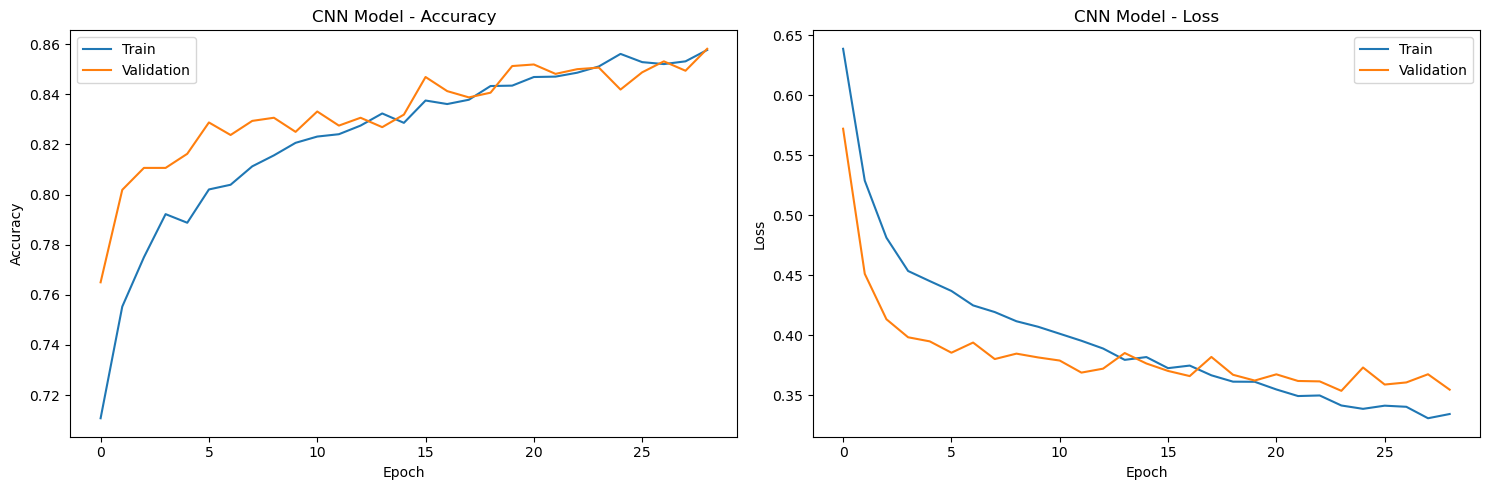

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8569 - loss: 0.3506
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8569 - loss: 0.3506

CNN Test Accuracy: 0.8590

Visualizing first convolutional layer activations...

CNN Test Accuracy: 0.8590

Visualizing first convolutional layer activations...


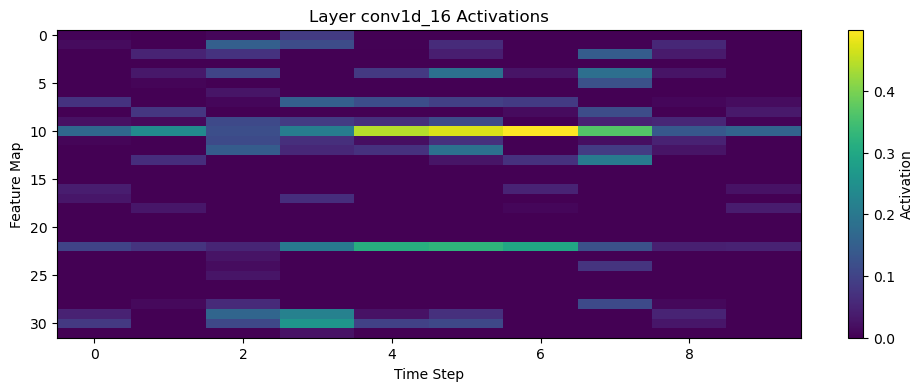

In [27]:
# Create and train CNN model
print("Training CNN model...")

# Initialize model
input_shape = (X_train_reshaped.shape[1], 1)
cnn_model = create_cnn_model(input_shape)

# Print model summary to see layer names
cnn_model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('cnn_model_best.h5', monitor='val_loss', save_best_only=True)
]

# Train model
cnn_history = cnn_model.fit(
    X_train_reshaped,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plot_training_history(cnn_history, 'CNN Model')

# Evaluate model
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test_reshaped, y_test)
print(f"\nCNN Test Accuracy: {cnn_test_accuracy:.4f}")

# Visualize the first convolutional layer's activations
sample_idx = 0
print("\nVisualizing first convolutional layer activations...")
visualize_conv_layer(cnn_model, X_test_reshaped[sample_idx])

## 2. Long Short-Term Memory (LSTM)

Implement an LSTM model for capturing sequential dependencies in malware features. LSTMs are particularly effective at learning long-range temporal dependencies and patterns in sequential data.

In [28]:
def create_lstm_model(input_shape):
    """Create an LSTM model for malware detection"""
    model = Sequential([
        # LSTM layers
        LSTM(64, input_shape=input_shape, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        
        LSTM(128, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        
        LSTM(64),
        BatchNormalization(),
        Dropout(0.3),
        
        # Dense layers for classification
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Training LSTM model...


c:\Users\thinkbook\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,625 (666.50 KB)

 Trainable params: 169,985 (664.00 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/50
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6258 - loss: 0.7847

200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6264 - loss: 0.7829 - val_accuracy: 0.5888 - val_loss: 0.6703
Epoch 2/50
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6928 - loss: 0.6194

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6928 - loss: 0.6193 - val_accuracy: 0.6531 - val_loss: 0.6301
Epoch 3/50
Epoch 3/50
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7207 - loss: 0.5750

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7208 - loss: 0.5749 - val_accuracy: 0.7531 - val_loss: 0.5238
Epoch 4/50
Epoch 4/50
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7258 - loss: 0.5545

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7259 - loss: 0.5544 - val_accuracy: 0.7506 - val_loss: 0.5011
Epoch 5/50
Epoch 5/50
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7243 - loss: 0.5417

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7245 - loss: 0.5415 - val_accuracy: 0.7525 - val_loss: 0.4816
Epoch 6/50
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7356 - loss: 0.5266 - val_accuracy: 0.7638 - val_loss: 0.4824
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7356 - loss: 0.5266 - val_accuracy: 0.7638 - val_loss: 0.4824
Epoch 7/50
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7373 - loss: 0.5265

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7375 - loss: 0.5262 - val_accuracy: 0.7544 - val_loss: 0.4800
Epoch 8/50
Epoch 8/50
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7541 - loss: 0.5033

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7541 - loss: 0.5032 - val_accuracy: 0.7731 - val_loss: 0.4734
Epoch 9/50
Epoch 9/50
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7496 - loss: 0.4994

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7498 - loss: 0.4990 - val_accuracy: 0.7831 - val_loss: 0.4665
Epoch 10/50
Epoch 10/50
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7585 - loss: 0.4868

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7589 - loss: 0.4864 - val_accuracy: 0.7788 - val_loss: 0.4348
Epoch 11/50
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7666 - loss: 0.4793 - val_accuracy: 0.7969 - val_loss: 0.4733
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7666 - loss: 0.4793 - val_accuracy: 0.7969 - val_loss: 0.4733
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7718 - loss: 0.4620

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7719 - loss: 0.4619 - val_accuracy: 0.8188 - val_loss: 0.4086
Epoch 13/50
Epoch 13/50
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7764 - loss: 0.4524

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7766 - loss: 0.4522 - val_accuracy: 0.8094 - val_loss: 0.4045
Epoch 14/50
Epoch 14/50
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7878 - loss: 0.4443

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7879 - loss: 0.4442 - val_accuracy: 0.8156 - val_loss: 0.3986
Epoch 15/50
Epoch 15/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7992 - loss: 0.4347 - val_accuracy: 0.8012 - val_loss: 0.4126
Epoch 16/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7992 - loss: 0.4347 - val_accuracy: 0.8012 - val_loss: 0.4126
Epoch 16/50
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7938 - loss: 0.4332

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7940 - loss: 0.4329 - val_accuracy: 0.8256 - val_loss: 0.3956
Epoch 17/50
Epoch 17/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8071 - loss: 0.4148 - val_accuracy: 0.8144 - val_loss: 0.3982
Epoch 18/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8071 - loss: 0.4148 - val_accuracy: 0.8144 - val_loss: 0.3982
Epoch 18/50
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8037 - loss: 0.4123

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8039 - loss: 0.4120 - val_accuracy: 0.8181 - val_loss: 0.3918
Epoch 19/50
Epoch 19/50
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8075 - loss: 0.4137

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8077 - loss: 0.4133 - val_accuracy: 0.8350 - val_loss: 0.3734
Epoch 20/50
Epoch 20/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8127 - loss: 0.4098 - val_accuracy: 0.8350 - val_loss: 0.3777
Epoch 21/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8127 - loss: 0.4098 - val_accuracy: 0.8350 - val_loss: 0.3777
Epoch 21/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8113 - loss: 0.4024

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8114 - loss: 0.4023 - val_accuracy: 0.8338 - val_loss: 0.3678
Epoch 22/50
Epoch 22/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8187 - loss: 0.3946

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8188 - loss: 0.3945 - val_accuracy: 0.8444 - val_loss: 0.3590
Epoch 23/50
Epoch 23/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8169 - loss: 0.3941 - val_accuracy: 0.8400 - val_loss: 0.3650
Epoch 24/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8169 - loss: 0.3941 - val_accuracy: 0.8400 - val_loss: 0.3650
Epoch 24/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8301 - loss: 0.3785 - val_accuracy: 0.8456 - val_loss: 0.3648
Epoch 25/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8301 - loss: 0.3785 - val_accuracy: 0.8456 - val_loss: 0.3648
Epoch 25/50
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8272 - loss: 0.3882

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8274 - loss: 0.3877 - val_accuracy: 0.8506 - val_loss: 0.3515
Epoch 26/50
Epoch 26/50
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8394 - loss: 0.3625

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8394 - loss: 0.3624 - val_accuracy: 0.8475 - val_loss: 0.3468
Epoch 27/50
Epoch 27/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8318 - loss: 0.3741 - val_accuracy: 0.8475 - val_loss: 0.3524
Epoch 28/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8318 - loss: 0.3741 - val_accuracy: 0.8475 - val_loss: 0.3524
Epoch 28/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8408 - loss: 0.3613 - val_accuracy: 0.8481 - val_loss: 0.3561
Epoch 29/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8408 - loss: 0.3613 - val_accuracy: 0.8481 - val_loss: 0.3561
Epoch 29/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8435 - loss: 0.3589 - val_accuracy: 0.8525 - val_loss: 0.3573
Epoch 30/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8435 - loss: 0.3589 - val_accuracy: 0.8525 - val_loss: 0.3573
Epoch 30/50
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8444 - loss: 0.3540

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8445 - loss: 0.3538 - val_accuracy: 0.8506 - val_loss: 0.3417
Epoch 31/50
Epoch 31/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8476 - loss: 0.3595 - val_accuracy: 0.8556 - val_loss: 0.3490
Epoch 32/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8476 - loss: 0.3595 - val_accuracy: 0.8556 - val_loss: 0.3490
Epoch 32/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8525 - loss: 0.3492 - val_accuracy: 0.8537 - val_loss: 0.3469
Epoch 33/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8525 - loss: 0.3492 - val_accuracy: 0.8537 - val_loss: 0.3469
Epoch 33/50
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8629 - loss: 0.3363

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8629 - loss: 0.3359 - val_accuracy: 0.8475 - val_loss: 0.3409
Epoch 34/50
Epoch 34/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8621 - loss: 0.3326 - val_accuracy: 0.8562 - val_loss: 0.3568
Epoch 35/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8621 - loss: 0.3326 - val_accuracy: 0.8562 - val_loss: 0.3568
Epoch 35/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8617 - loss: 0.3251 - val_accuracy: 0.8606 - val_loss: 0.3458
Epoch 36/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8617 - loss: 0.3251 - val_accuracy: 0.8606 - val_loss: 0.3458
Epoch 36/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8723 - loss: 0.3057 - val_accuracy: 0.8500 - val_loss: 0.3494
Epoch 37/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8723 - loss: 0.3057 - val_accuracy: 0.8500 - val_loss: 0.3494
Epoch 37/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8657 - loss: 0.3170 - 

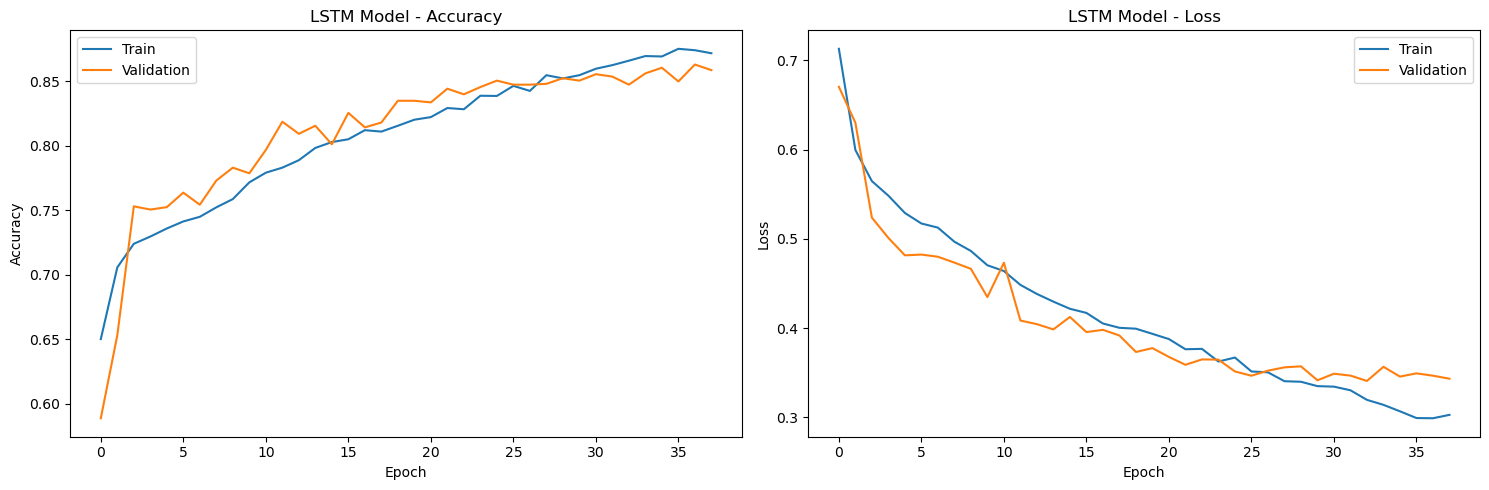

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8573 - loss: 0.3465
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8573 - loss: 0.3465

LSTM Test Accuracy: 0.8610

Visualizing first LSTM layer activations...

LSTM Test Accuracy: 0.8610

Visualizing first LSTM layer activations...


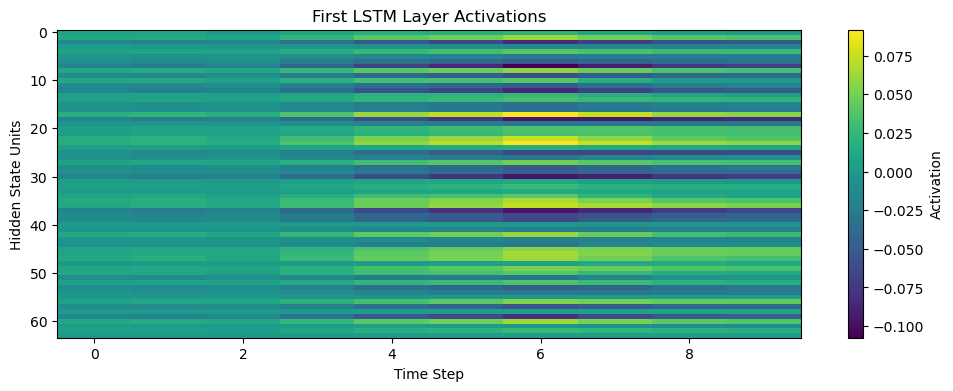

In [29]:
# Create and train LSTM model
print("Training LSTM model...")

# Initialize model
input_shape = (X_train_reshaped.shape[1], 1)
lstm_model = create_lstm_model(input_shape)

# Print model summary
lstm_model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('lstm_model_best.h5', monitor='val_loss', save_best_only=True)
]

# Train model
lstm_history = lstm_model.fit(
    X_train_reshaped,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plot_training_history(lstm_history, 'LSTM Model')

# Evaluate model
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test_reshaped, y_test)
print(f"\nLSTM Test Accuracy: {lstm_test_accuracy:.4f}")

# Visualize LSTM layer activations
sample_idx = 0
print("\nVisualizing first LSTM layer activations...")

# Create a model for LSTM visualization
inputs = Input(shape=input_shape)
x = LSTM(64, return_sequences=True)(inputs)
feature_model = Model(inputs=inputs, outputs=x)

# Get activations
activations = feature_model.predict(X_test_reshaped[sample_idx:sample_idx+1], verbose=0)

# Plot activations
plt.figure(figsize=(12, 4))
plt.imshow(activations[0].T, aspect='auto', cmap='viridis')
plt.title('First LSTM Layer Activations')
plt.xlabel('Time Step')
plt.ylabel('Hidden State Units')
plt.colorbar(label='Activation')
plt.show()

## 3. Multi-Layer Perceptron (MLP)

Implement an MLP model for learning non-linear feature combinations. MLPs are effective at finding complex patterns in the raw feature space without assuming temporal or sequential structure.

In [30]:
def create_mlp_model(input_shape):
    """Create an MLP model for malware detection"""
    model = Sequential([
        # Flatten the input
        tf.keras.layers.Flatten(input_shape=input_shape),
        
        # First Dense Block
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second Dense Block
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Third Dense Block
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Training MLP model...


c:\Users\thinkbook\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,825 (179.00 KB)

 Trainable params: 44,929 (175.50 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7017 - loss: 0.6278

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7038 - loss: 0.6238 - val_accuracy: 0.7250 - val_loss: 0.5489
Epoch 2/50
Epoch 2/50
185/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7731 - loss: 0.4867

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7737 - loss: 0.4857 - val_accuracy: 0.8056 - val_loss: 0.4455
Epoch 3/50
Epoch 3/50
182/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7811 - loss: 0.4625

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7821 - loss: 0.4614 - val_accuracy: 0.8062 - val_loss: 0.4152
Epoch 4/50
Epoch 4/50
173/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7844 - loss: 0.4501

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7855 - loss: 0.4486 - val_accuracy: 0.8156 - val_loss: 0.3983
Epoch 5/50
Epoch 5/50
183/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7911 - loss: 0.4342

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7920 - loss: 0.4334 - val_accuracy: 0.8106 - val_loss: 0.3982
Epoch 6/50
Epoch 6/50
191/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8056 - loss: 0.4275

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8058 - loss: 0.4270 - val_accuracy: 0.8219 - val_loss: 0.3903
Epoch 7/50
Epoch 7/50
183/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8100 - loss: 0.4183

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8108 - loss: 0.4174 - val_accuracy: 0.8206 - val_loss: 0.3866
Epoch 8/50
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8090 - loss: 0.4126 - val_accuracy: 0.8231 - val_loss: 0.3896
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8090 - loss: 0.4126 - val_accuracy: 0.8231 - val_loss: 0.3896
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8193 - loss: 0.4113 - val_accuracy: 0.8313 - val_loss: 0.3976
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8193 - loss: 0.4113 - val_accuracy: 0.8313 - val_loss: 0.3976
Epoch 10/50
179/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8195 - loss: 0.4029

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8202 - loss: 0.4015 - val_accuracy: 0.8344 - val_loss: 0.3746
Epoch 11/50
Epoch 11/50
182/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8238 - loss: 0.3891

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8245 - loss: 0.3881 - val_accuracy: 0.8256 - val_loss: 0.3740
Epoch 12/50
Epoch 12/50
182/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8176 - loss: 0.3946

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8186 - loss: 0.3939 - val_accuracy: 0.8369 - val_loss: 0.3702
Epoch 13/50
  1/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8750 - loss: 0.3466Epoch 13/50
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8327 - loss: 0.3803

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8329 - loss: 0.3800 - val_accuracy: 0.8338 - val_loss: 0.3670
Epoch 14/50
Epoch 14/50
171/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8283 - loss: 0.3846

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8297 - loss: 0.3826 - val_accuracy: 0.8419 - val_loss: 0.3603
Epoch 15/50
Epoch 15/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8358 - loss: 0.3694 - val_accuracy: 0.8356 - val_loss: 0.3677
Epoch 16/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8358 - loss: 0.3694 - val_accuracy: 0.8356 - val_loss: 0.3677
Epoch 16/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8357 - loss: 0.3716 - val_accuracy: 0.8319 - val_loss: 0.3666
Epoch 17/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8357 - loss: 0.3716 - val_accuracy: 0.8319 - val_loss: 0.3666
Epoch 17/50
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8370 - loss: 0.3663

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8372 - loss: 0.3660 - val_accuracy: 0.8400 - val_loss: 0.3587
Epoch 18/50
Epoch 18/50
171/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8467 - loss: 0.3531

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8465 - loss: 0.3526 - val_accuracy: 0.8481 - val_loss: 0.3484
Epoch 19/50
Epoch 19/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8483 - loss: 0.3528 - val_accuracy: 0.8450 - val_loss: 0.3534
Epoch 20/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8483 - loss: 0.3528 - val_accuracy: 0.8450 - val_loss: 0.3534
Epoch 20/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8464 - loss: 0.3498 - val_accuracy: 0.8444 - val_loss: 0.3585
Epoch 21/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8464 - loss: 0.3498 - val_accuracy: 0.8444 - val_loss: 0.3585
Epoch 21/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8536 - loss: 0.3448 - val_accuracy: 0.8456 - val_loss: 0.3498
Epoch 22/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8536 - loss: 0.3448 - val_accuracy: 0.8456 - val_loss: 0.3498
Epoch 22/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8524 - loss: 0.3466 - val_accu

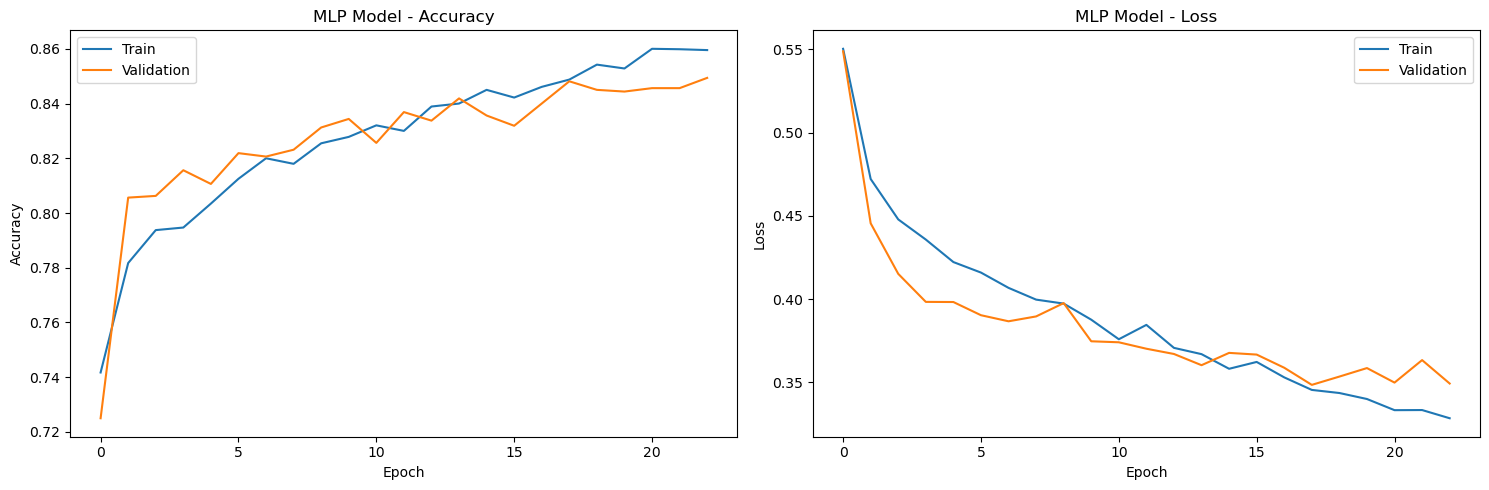

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8536 - loss: 0.3856 
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8536 - loss: 0.3856

MLP Test Accuracy: 0.8555

Visualizing first dense layer activations...

MLP Test Accuracy: 0.8555

Visualizing first dense layer activations...


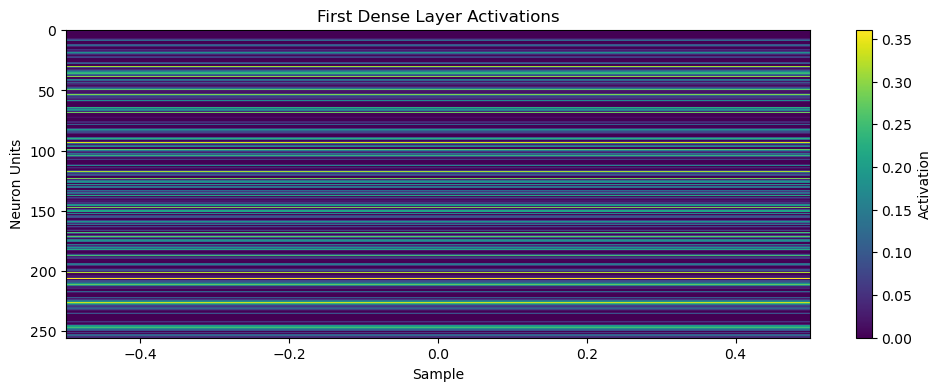

In [31]:
# Create and train MLP model
print("Training MLP model...")

# Initialize model
input_shape = (X_train_reshaped.shape[1], 1)
mlp_model = create_mlp_model(input_shape)

# Print model summary
mlp_model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('mlp_model_best.h5', monitor='val_loss', save_best_only=True)
]

# Train model
mlp_history = mlp_model.fit(
    X_train_reshaped,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plot_training_history(mlp_history, 'MLP Model')

# Evaluate model
mlp_test_loss, mlp_test_accuracy = mlp_model.evaluate(X_test_reshaped, y_test)
print(f"\nMLP Test Accuracy: {mlp_test_accuracy:.4f}")

# Visualize first dense layer activations
sample_idx = 0
print("\nVisualizing first dense layer activations...")

# Create a model for dense layer visualization
inputs = Input(shape=input_shape)
x = tf.keras.layers.Flatten()(inputs)
x = Dense(256, activation='relu')(x)
feature_model = Model(inputs=inputs, outputs=x)

# Get activations
activations = feature_model.predict(X_test_reshaped[sample_idx:sample_idx+1], verbose=0)

# Plot activations
plt.figure(figsize=(12, 4))
plt.imshow(activations.T, aspect='auto', cmap='viridis')
plt.title('First Dense Layer Activations')
plt.xlabel('Sample')
plt.ylabel('Neuron Units')
plt.colorbar(label='Activation')
plt.show()

## Model Comparison

Compare the performance of all three architectures (CNN, LSTM, and MLP) on the malware detection task.

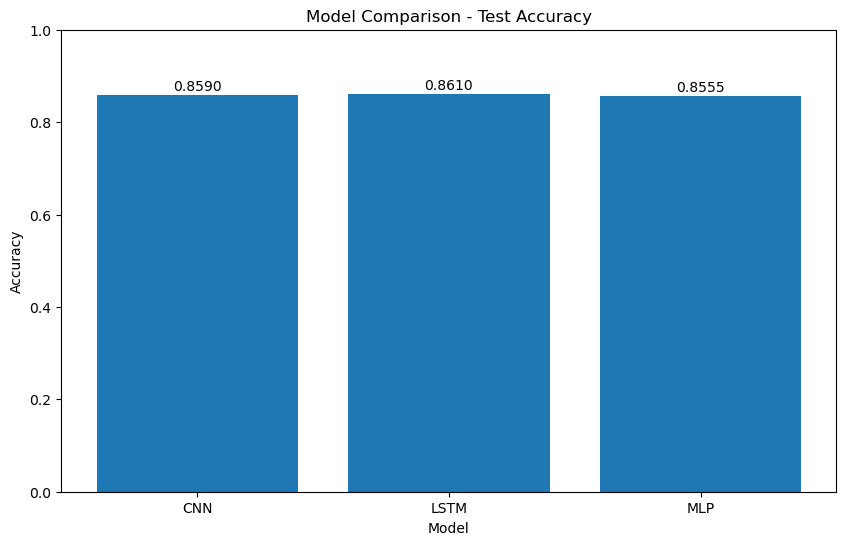


Model Performance Summary:
CNN Test Accuracy: 0.8590
LSTM Test Accuracy: 0.8610
MLP Test Accuracy: 0.8555


: 

In [ ]:
# Compare model accuracies
model_names = ['CNN', 'LSTM', 'MLP']
test_accuracies = [cnn_test_accuracy, lstm_test_accuracy, mlp_test_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(model_names, test_accuracies)
plt.title('Model Comparison - Test Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add accuracy values on top of bars
for i, acc in enumerate(test_accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.show()

# Print comparison summary
print("\nModel Performance Summary:")
for name, acc in zip(model_names, test_accuracies):
    print(f"{name} Test Accuracy: {acc:.4f}")